In [1]:
%load_ext autoreload
from ddls.devices.processors.gpus.A100 import A100
from ddls.plotting.plotting import plot_computation_graph
from ddls.environments.ramp_job_placement_shaping.ramp_job_placement_shaping_environment import RampJobPlacementShapingEnvironment
from ddls.demands.jobs.job import Job
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

from ddls.ml_models.policies import GNNPolicy
from ddls.plotting.plotting import plot_line

from ddls.loops.rllib_epoch_loop import RLlibEpochLoop
from ddls.launchers.launcher import Launcher

import ray
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
ray.shutdown()
ray.init()

from ray.rllib.models import ModelCatalog
from ray.rllib.agents import ppo

import glob
import numpy as np
from collections import defaultdict

2022-06-23 13:38:16,217	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8269
2022-06-23 13:38:23,473	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8269


In [2]:
%autoreload
register_env('ramp_job_placement_shaping_environment', lambda env_config: RampJobPlacementShapingEnvironment(**env_config))

In [3]:
%autoreload
ModelCatalog.register_custom_model('my_model', GNNPolicy)

In [4]:
%autoreload

node_config = {'type_1':
                  {
                      'num_nodes': 16, # 8 16
                      'workers_config': 
                          [
                              {
                               'num_workers': 1, # NEED 1 WORKER PER SERVER FOR RAMP
                               'worker': A100
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'ramp',
                   'kwargs':
                      {
                          'num_communication_groups': 2,
                          'num_racks_per_communication_group': 2,
                          'num_servers_per_rack': 4, # 2 4
                          'num_channels': 2,
                          'channel_bandwidth': int(1.25e9)
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/pipedream_graphs/image_classification/profiles/alexnet/',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 20,
               'job_sampling_mode': 'remove',
               # 'job_sampling_mode': 'remove_and_replace',
               }

In [5]:
env_config = {'node_config': node_config,
              'topology_config': topology_config,
              'jobs_config': jobs_config,
              # 'max_simulation_run_time': 1e4,
              'max_simulation_run_time': float('inf'),
              'job_queue_capacity': 100,
              'reward_function': 'lookahead_job_completion_time',
              'pad_obs_kwargs': {'max_nodes': 200}
             }

model_config = {
        'in_features_node':5,
        'in_features_edge':1,
        'out_features_msg':8,
        'out_features_hidden':16,
        'out_features':4,
        'in_features_graph':34, # CHANGE 130
        'out_features_graph':4,
        'num_layers':1,
        'aggregator_type':'mean',
        'action_space_type': 'discrete' # 'discrete' 'continuous'
    }



rllib_config = {
    
    'seed': 0,
    
    'env': 'ramp_job_placement_shaping_environment',
    
    'env_config': env_config,
    
    'batch_mode': 'complete_episodes',
    'train_batch_size': 4, # 1 32 128
    'sgd_minibatch_size': 4, # 1 32 128
    
    'model':{
            'fcnet_hiddens':[8],
            'fcnet_activation':'relu',
            'custom_model':'my_model',
            'custom_model_config': model_config
        },
    
    'num_workers': 4,
    'num_gpus': 1,
    
    'framework': 'torch'
    
    }

print(rllib_config)

{'seed': 0, 'env': 'ramp_job_placement_shaping_environment', 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 1, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}, 'topology_config': {'type': 'ramp', 'kwargs': {'num_communication_groups': 2, 'num_racks_per_communication_group': 2, 'num_servers_per_rack': 4, 'num_channels': 2, 'channel_bandwidth': 1250000000}}, 'jobs_config': {'path_to_files': '/scratch/datasets/ddls/jobs/pipedream_graphs/image_classification/profiles/alexnet/', 'job_interarrival_time_dist': <ddls.distributions.uniform.Uniform object at 0x7f945b7eb640>, 'max_files': 20, 'job_sampling_mode': 'remove'}, 'max_simulation_run_time': inf, 'job_queue_capacity': 100, 'reward_function': 'lookahead_job_completion_time', 'pad_obs_kwargs': {'max_nodes': 200}}, 'batch_mode': 'complete_episodes', 'train_batch_size': 4, 'sgd_minibatch_size': 4, 'model': {'fcnet_hiddens': [8], 'fcnet_activation': 'relu', 'custom_model': 'my_mode

In [6]:
%autoreload

# load default PPO config and update with custom config params
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(rllib_config)
print(f'Config:\n{ppo_config}')

# initialise rllib trainer
epoch_loop = ppo.PPOTrainer(config=ppo_config)
print('\nInitialised trainer.')

2022-06-23 13:38:25,975	WARNING ppo.py:143 -- `train_batch_size` (4) cannot be achieved with your other settings (num_workers=4 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1.
2022-06-23 13:38:25,975	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-06-23 13:38:25,976	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Config:
{'num_workers': 4, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 4, 'model': {'fcnet_hiddens': [8], 'fcnet_activation': 'relu', 'custom_model': 'my_model', 'custom_model_config': {'in_features_node': 5, 'in_features_edge': 1, 'out_features_msg': 8, 'out_features_hidden': 16, 'out_features': 4, 'in_features_graph': 34, 'out_features_graph': 4, 'num_layers': 1, 'aggregator_type': 'mean', 'action_space_type': 'discrete'}}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'ramp_job_placement_shaping_environment', 'observation_space': None, 'action_space': None, 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 1, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}, 'topology_config': {'type': 'ramp', 'kwargs': {'num_communication_groups': 2, 'num_racks_per_communic

(RolloutWorker pid=2921216) 2022-06-23 13:38:35,194	WARNING catalog.py:544 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=2921211) 2022-06-23 13:38:35,802	WARNING catalog.py:544 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=2921212) 2022-06-23 13:38:35,928	WARNING catalog.py:544 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=2921213) 2022-06-23 13:38:35,965	WARNING catalog.py:544 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-06-23 13:38:37,572	WARNING catalog.py:544 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-06-23 13:38:43,889	INFO trai


Initialised trainer.


In [7]:
%autoreload

agent_name = 'PPO'
num_epochs = 10 # 500
rl_training_stats = defaultdict(lambda: [])
for epoch in range(num_epochs):
    print(f'\n------- Epoch {epoch+1} of {num_epochs} -------')
    result = epoch_loop.train()
    
    # print epoch data
    print(pretty_print(result))
    
    # save epoch data
    for key, val in result['hist_stats'].items():
        rl_training_stats[key].extend(val)
    for _ in range(len(val)):
        rl_training_stats['seed'].append(result['config']['seed'])
        rl_training_stats['agent'].append(agent_name)
        rl_training_stats['epoch'].append(epoch)
        
# display(pd.DataFrame(rl_training_stats))


------- Epoch 1 of 10 -------


(RolloutWorker pid=2921212) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
(RolloutWorker pid=2921212)   ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/ray/rllib/utils/metrics/learner_info.py:84: RuntimeWarning: Mean of empty slice
  return np.nanmean(tower_data)
/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/ray/rllib/utils/metrics/learner_info.py:64: RuntimeWarning: Mean of empty slice
  lambda *s: None if s[0] is None else np.nanmean(s, axis=0),


agent_timesteps_total: 4
custom_metrics: {}
date: 2022-06-23_13-38-45
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0013693919704467286
episode_reward_mean: 0.0013693919650025483
episode_reward_min: 0.001369391959558368
episodes_this_iter: 4
episodes_total: 4
experiment_id: d4800caf4273443b99985ab8ca0b2159
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.20000000000000007
        cur_lr: 4.999999999999999e-05
        entropy: 2.639056841532389
        entropy_coeff: 0.0
        kl: -1.4651812515846056e-07
        policy_loss: 0.0
        total_loss: 1.1700356541410884e-07
        vf_explained_var: .nan
        vf_loss: 1.4630718965143638e-07
  num_agent_steps_sampled: 4
  num_agent_steps_trained: 4
  num_steps_sampled: 4
  num_steps_trained: 4
iterations_since_restore: 1
node_ip: 128.40.41.23
num_healthy_workers: 4
off_policy_estimator: {}
perf:
  cpu_util_percent: 27.066666666666666
  ram_util_

(RolloutWorker pid=2921213) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=2921213)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=2921213) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=2921213)   ret = ret.dtype.type(ret / rcount)


agent_timesteps_total: 12
custom_metrics: {}
date: 2022-06-23_13-38-49
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0013693919704467286
episode_reward_mean: -0.08208191769658572
episode_reward_min: -1.0
episodes_this_iter: 4
episodes_total: 12
experiment_id: d4800caf4273443b99985ab8ca0b2159
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.05000000000000002
        cur_lr: 4.999999999999999e-05
        entropy: 2.6390539248784384
        entropy_coeff: 0.0
        kl: 1.224742967072719e-06
        policy_loss: -0.0014624486366907755
        total_loss: 0.24834414621194204
        vf_explained_var: -2.7815500895182292e-08
        vf_loss: 0.24980653127034505
  num_agent_steps_sampled: 12
  num_agent_steps_trained: 12
  num_steps_sampled: 12
  num_steps_trained: 12
  num_steps_trained_this_iter: 0
iterations_since_restore: 3
node_ip: 128.40.41.23
num_healthy_workers: 4
off_policy_estimator: {}
per

(RolloutWorker pid=2921213) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=2921213)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=2921213) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=2921213)   ret = ret.dtype.type(ret / rcount)


agent_timesteps_total: 28
custom_metrics: {}
date: 2022-06-23_13-38-58
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0013693919704467286
episode_reward_mean: -0.07016021578558808
episode_reward_min: -1.0
episodes_this_iter: 4
episodes_total: 28
experiment_id: d4800caf4273443b99985ab8ca0b2159
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.003125000000000001
        cur_lr: 4.999999999999999e-05
        entropy: 2.6390395561854043
        entropy_coeff: 0.0
        kl: 9.272976058127824e-07
        policy_loss: -0.0014871646960576375
        total_loss: 0.2460686296224594
        vf_explained_var: -7.947285970052083e-09
        vf_loss: 0.24755580375591915
  num_agent_steps_sampled: 28
  num_agent_steps_trained: 28
  num_steps_sampled: 28
  num_steps_trained: 28
  num_steps_trained_this_iter: 0
iterations_since_restore: 7
node_ip: 128.40.41.23
num_healthy_workers: 4
off_policy_estimator: {}
perf

(RolloutWorker pid=2921216) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=2921216)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=2921216) /scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=2921216)   ret = ret.dtype.type(ret / rcount)


agent_timesteps_total: 32
custom_metrics: {}
date: 2022-06-23_13-39-00
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0013693919704467286
episode_reward_mean: -0.09251210361588993
episode_reward_min: -1.0
episodes_this_iter: 4
episodes_total: 32
experiment_id: d4800caf4273443b99985ab8ca0b2159
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.0015625000000000005
        cur_lr: 4.999999999999999e-05
        entropy: 2.639030702908834
        entropy_coeff: 0.0
        kl: 2.090935898498477e-06
        policy_loss: -0.002351685365041097
        total_loss: 0.24301886955897015
        vf_explained_var: -7.947285970052083e-09
        vf_loss: 0.24537054002285003
  num_agent_steps_sampled: 32
  num_agent_steps_trained: 32
  num_steps_sampled: 32
  num_steps_trained: 32
  num_steps_trained_this_iter: 0
iterations_since_restore: 8
node_ip: 128.40.41.23
num_healthy_workers: 4
off_policy_estimator: {}
perf

Plotting metric episode_lengths


<Figure size 640x480 with 0 Axes>

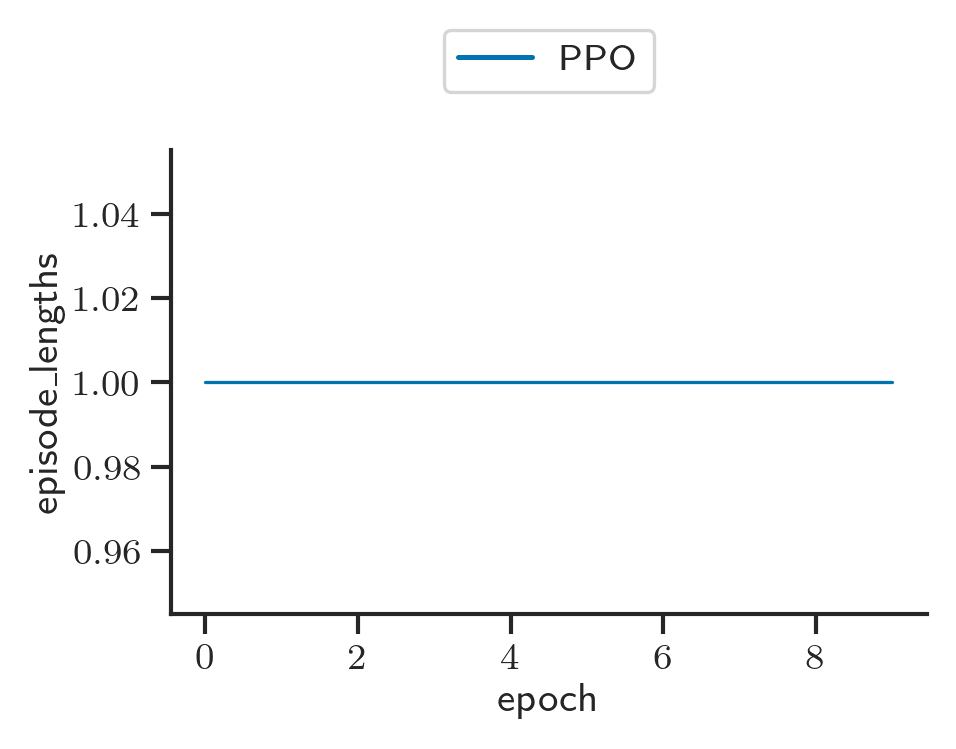

Plotting metric episode_reward


<Figure size 1920x1440 with 0 Axes>

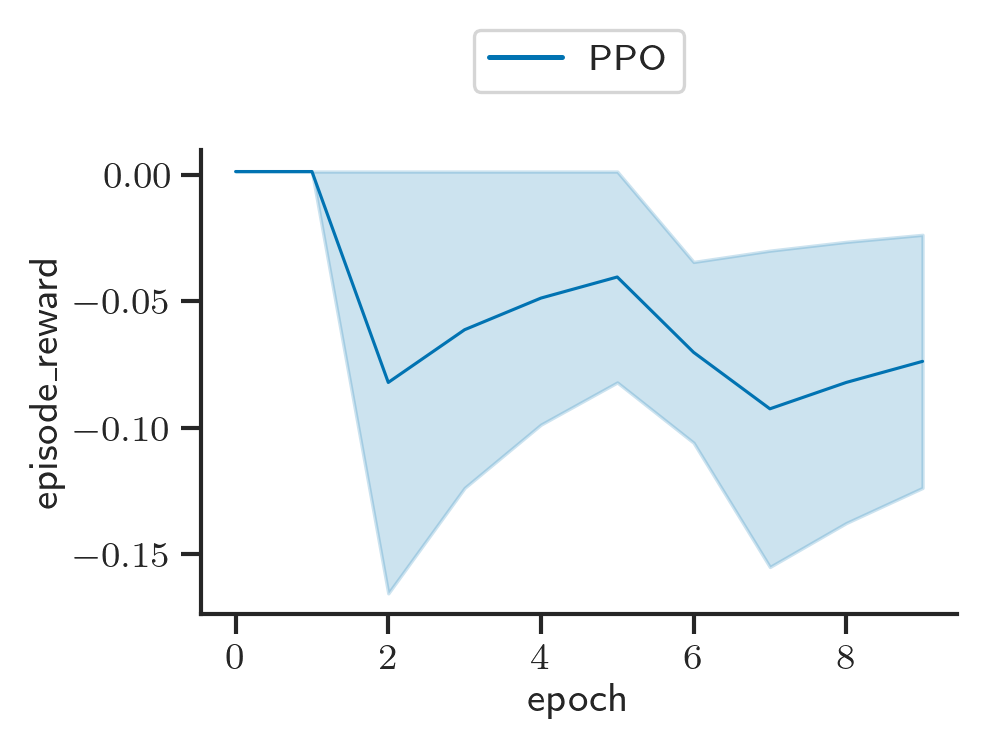

2022-06-23 13:39:37,683	WARNING worker.py:1245 -- (ip=128.40.41.23) The agent on node mammoth.ee.ucl.ac.uk failed to be restarted 5 times. There are 3 possible problems if you see this error.
  1. The dashboard might not display correct information on this node.
  2. Metrics on this node won't be reported.
  3. runtime_env APIs won't work.
Check out the `dashboard_agent.log` to see the detailed failure messages.


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

x = 'epoch'
scaling_factor = 1
metrics_to_plot = {'episode_reward', 'episode_lengths'}

for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    fig = plt.figure()
    fig = plot_line(pd.DataFrame(rl_training_stats), 
                    x=x, 
                    y=metric, 
                    hue='agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
#     plt.axhline(y=np.mean(random_baseline_stats[metric]), linestyle='--', color='#a84a32', label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()